<a href="https://colab.research.google.com/github/AndresChauca/Drone-Proyect-Saturdays-AI/blob/master/Drone_Proyect_Saturdays_AI_with_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Distanciamiento de Personas**
## *Drone Proyect Saturdays AI* 

>![alt text](https://raw.githubusercontent.com/AndresChauca/Drone-Proyect-Saturdays-AI/master/logoai6uio.png)



Este algoritmo se enfoca en la deteccion de personas a traves de un sistema de detección de objetos en tiempo real llamado YOLOv3 y a la vez realiza una verificacion del distanciamiento entre ellas. El algoritmo queda dividio en la siguientes secciones:


-   Con [YOLOv3](https://pjreddie.com/darknet/yolo/) podemos detectar objetos a una velocidad relativamente alta. Con una GPU podríamos procesar más de 45 cuadros/segundo mientras que con una CPU alrededor de un cuadro por segundo 


## Habilitar la GPU

Primero, deberá habilitar las GPU para el portátil:

- Navegue a Editar → Configuración del cuaderno
- seleccione GPU del menú desplegable Acelerador de hardware


## Imports

In [3]:
import cv2
import urllib.request
import numpy as np
from matplotlib import pyplot as plt
cv2.__version__


'4.1.2'

## Enviroment setup

In [0]:
# This is needed to display the images.
%matplotlib inline

## Cargando yolov3
Para ejecutar el algoritmo necesitamos tres archivos:

**Archivo de peso:** es el modelo entrenado, el núcleo del algoritmo para detectar los objetos.

**Archivo Cfg :** es el archivo de configuración, donde hay todas las configuraciones del algoritmo.

**Archivos de nombre:** contiene el nombre de los objetos que el algoritmo puede detectar.

In [10]:
# Descargar yolov3.weights en una carpeta temporal
!wget --no-check-certificate \
    https://pjreddie.com/media/files/yolov3.weights \
    -O /tmp/yolov3.weights

# Descargar yolov3.cfg en una carpeta temporal
!wget --no-check-certificate \
    https://raw.githubusercontent.com/ultralytics/yolov3/master/cfg/yolov3.cfg \
    -O /tmp/yolov3.cfg

# Descargar coco.names en una carpeta temporal
!wget --no-check-certificate \
    https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names \
    -O /tmp/coco.names

--2020-05-07 13:27:08--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘/tmp/yolov3.weights’

/tmp/yolov3.weights 100%[===================>] 236.52M   285KB/s    in 12m 5s  

2020-05-07 13:39:14 (334 KB/s) - ‘/tmp/yolov3.weights’ saved [248007048/248007048]

--2020-05-07 13:39:15--  https://raw.githubusercontent.com/ultralytics/yolov3/master/cfg/yolov3.cfg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8338 (8.1K) [text/plain]
Saving to: ‘/tmp/yolov3.cfg’

/tmp/yolov3.cfg     100%[===================>]   8.14K  --.-KB/s    i

In [0]:
net = cv2.dnn.readNetFromDarknet("/tmp/yolov3.cfg","/tmp/yolov3.weights")
classes = []
with open("/tmp/coco.names", "r") as f:
    classes = [line.strip() for line in f.readlines()]
layer_names = net.getLayerNames()
output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
colors = np.random.uniform(0, 255, size=(len(classes), 3))

## Cargando imagen
Luego cargamos la imagen donde queremos realizar la detección de objetos y también obtenemos su ancho y alto.

In [78]:
# URLs de imagenes
# https://c8.alamy.com/compes/mb6awd/desde-arriba-gente-de-negocios-y-el-saludo-de-enlace-se-reunio-en-el-concurrido-hall-de-la-organizacion-mb6awd.jpg
# https://media.istockphoto.com/photos/top-view-people-walking-white-floor-or-large-crowd-of-anonymous-picture-id1178084326 
# https://c8.alamy.com/compes/fj415m/la-gente-en-la-plaza-los-peatones-caminar-visto-desde-arriba-de-alta-vista-fj415m.jpg
# https://thumbs.dreamstime.com/z/gente-que-camina-y-toma-las-fotos-en-un-cuadrado-grande-129222318.jpg

# Descargar una imagen descargada en un repositorio temporal
!wget --no-check-certificate \
    https://c8.alamy.com/compes/fj415m/la-gente-en-la-plaza-los-peatones-caminar-visto-desde-arriba-de-alta-vista-fj415m.jpg  \
    -O /tmp/personas.jpg

--2020-05-07 13:59:26--  https://c8.alamy.com/compes/fj415m/la-gente-en-la-plaza-los-peatones-caminar-visto-desde-arriba-de-alta-vista-fj415m.jpg
Resolving c8.alamy.com (c8.alamy.com)... 54.153.50.113, 54.193.28.57
Connecting to c8.alamy.com (c8.alamy.com)|54.153.50.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘/tmp/personas.jpg’

/tmp/personas.jpg       [ <=>                ] 220.04K  --.-KB/s    in 0.1s    

Last-modified header invalid -- time-stamp ignored.
2020-05-07 13:59:26 (1.75 MB/s) - ‘/tmp/personas.jpg’ saved [225322]



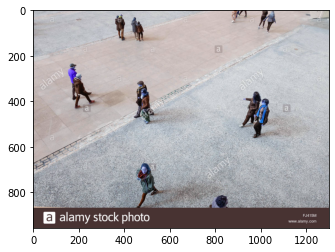

In [79]:
img = cv2.imread("/tmp/personas.jpg")

img = cv2.resize(img, None, fx=1, fy=1)
height, width, channels = img.shape

plt.imshow(img)

## Detectando objetos
Aplicamos una única red neuronal a la imagen completa. Esta red divide la imagen en regiones y predice cuadros delimitadores y probabilidades para cada región. Estos cuadros delimitadores están ponderados por las probabilidades predichas.

Ahora pasamos la imagen a la red para hacer la detección, pero antes necesitamos para convertirla en blob, este se utiliza para extraer características de la imagen y cambiar su tamaño. YOLO acepta tres tamaños:

**320 × 320** es pequeño, así que menos precisión pero mejor velocidad

**416 × 416** está en el medio y obtienes un poco de ambos.

**608 × 608** es más grande, así que alta precisión y velocidad lenta


In [0]:
blob = cv2.dnn.blobFromImage(img, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
net.setInput(blob)
outs = net.forward(output_layers)

Las salidas son el resultado de la detección. outs es una matriz que contiene toda la información sobre los objetos detectados, su posición y la confianza en la detección.

## Obtencion las cordenadas de los rectangulos (boxes) de cada detección
Recorremos el conjunto de salidas, calculamos la confianza y elegimos un umbral de confianza, establecido en 0,5; si es mayor, consideramos que el objeto se detectó correctamente; de ​​lo contrario, lo omitimos.

El umbral va de 0 a 1. Cuanto más cercano a 1, mayor es la precisión de la detección, mientras que cuanto más cercano a 0, menor es la precisión, pero también es mayor el número de objetos detectados.

In [0]:
class_ids = []
confidences = []
boxes = []
for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > 0.5:

            # Object detected
            center_x = int(detection[0] * width)
            center_y = int(detection[1] * height)
            w = int(detection[2] * width)
            h = int(detection[3] * height)

            # Rectangle coordinates
            x = int(center_x - w / 2)
            y = int(center_y - h / 2)
            boxes.append([x, y, w, h])
            confidences.append(float(confidence))
            class_ids.append(class_id)

Cuando realizamos la detección, sucede que tenemos más cuadros para el mismo objeto, por lo que deberíamos usar otra función para eliminar este "ruido".
Se llama supresión no máxima.

In [0]:
indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

## Mostrando información en la pantalla

Extraemos toda la información y la mostramos en la pantalla.

Cuadro : contiene las coordenadas del rectángulo alrededor del objeto detectado.
Etiqueta : es el nombre del objeto detectado
Confianza : la confianza sobre la detección de 0 a 1.

box coords:  0   [169, 266, 100, 159] labels: person
******************************
box coords:  1   [450, 336, 75, 158] labels: person
******************************
box coords:  2   [902, 358, 87, 155] labels: person
******************************
box coords:  3   [966, 388, 75, 159] labels: person
******************************
box coords:  4   [446, 668, 98, 213] labels: person
******************************
box coords:  5   [867, -1, 38, 51] labels: person
******************************
box coords:  6   [992, 0, 39, 81] labels: person
******************************
box coords:  7   [1014, 3, 50, 92] labels: person
******************************
box coords:  8   [367, 18, 38, 115] labels: person
******************************
box coords:  9   [427, 29, 31, 100] labels: person
******************************
box coords:  10   [447, 39, 37, 97] labels: person
******************************
box coords:  11   [775, 814, 82, 53] labels: person
******************************


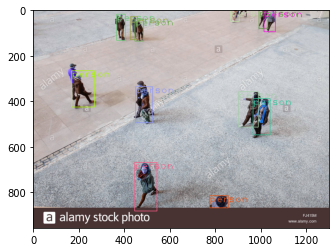

In [83]:
font = cv2.FONT_HERSHEY_PLAIN
ellipses = []

for i in range(len(boxes)):
    if i in indexes:
      # El siguiente if es para que detecte solo personas, la clases persona tiene el class_id = o
      if class_ids[i] == 0: # comentar esta linea si desea detectar cualquier objeto 
        x, y, w, h = boxes[i]
        label = str(classes[class_ids[i]])
        print("box coords: ", i, " ", boxes[i], "labels:", label)
        color = colors[i]
  
        # >>>>>>>>>>>>>>>>> PERSPECTIVA CONFIGURABLE <<<<<<<<<<<<<<<<<<<<<

        # Se configura la longitud de los ejes de la elipse segun la perspectiva donde se encuentre la persona en la imagen
        # Se dividio en tres secciones; y+h es la posicion en pixeles de la base del box
        if y+h <= height/3: # personas que estan mas lejos, al fondo
           axes_w = int(width*8.5/100) # 9% del tamaño de la imagen
           axes_h = int(width*6/100)
        elif y+h > height/3 and y+h < 2*height/3: # personas que estan en la parte central
           axes_w = int(width*9/100) # 9.5% del tamaño de la imagen
           axes_h = int(width*6.5/100)
        else:  # personas que estan mas cerca 
           axes_w = int(width*9.5/100) # 10% del tamaño de la imagen
           axes_h = int(width*7/100)

        # guardo las coordenadas de las elipses
        ellipses.append([int(x+w/2), y+h, axes_w, axes_h, 0])

        cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
        cv2.putText(img, label, (x, y + 30), font, 3, color, 2)

        print('*' * 30)        

plt.imshow(img)
#plt.axis('Off')
plt.show()

A continuación se declaran dos metodos:
* **ellipse_polyline**: para expresar las elipses en ecuaciones parametricas
* **intersections**: para encontrar los puntos de interseccion entre dos elipses

In [0]:
from shapely.geometry.polygon import LinearRing

# Se crea una mascara para las elipses
mask = img.copy()
mask[:,:,0]=0
mask[:,:,1]=0
mask[:,:,2]=0

def ellipse_polyline(ellipses, n=100):
       t = np.linspace(0, 2*np.pi, n, endpoint=False)
       st = np.sin(t)
       ct = np.cos(t)
       result = []
       for x0, y0, a, b, angle in ellipses:
           angle = np.deg2rad(angle)
           sa = np.sin(angle)
           ca = np.cos(angle)
           p = np.empty((n, 2))
           p[:, 0] = x0 + a * ca * ct - b * sa * st
           p[:, 1] = y0 + a * sa * ct + b * ca * st

           result.append(p)
       return result

def intersections(a, b):
       ea = LinearRing(a)
       eb = LinearRing(b)
       mp = ea.intersection(eb)

       x = [p.x for p in mp]
       y = [p.y for p in mp]
       return x, y

Finalmente se dibujan las Ellipses de dos colores:
- Elipse verde: mantiene la distancia adecuada, zona segura
- Elipse roja: no se mantiene la distancia adecuada, zona no segura
Para determinar lo anterior se buscan puntos de interseccion entre elipses, si existen tales puntos la elipse cambia a color rojo.

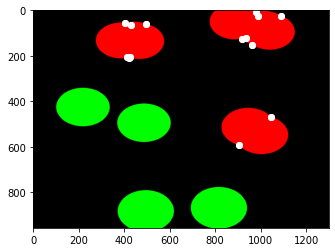

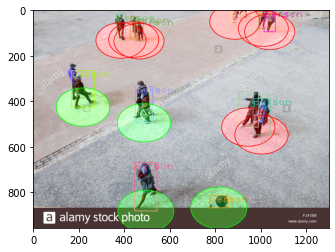

In [85]:
x_=[]
y_=[]
elip = ellipse_polyline(ellipses)
for i in range(len(ellipses)): # Tomo una por una las elipses de cada box 
    x0, y0, a, b, angle = ellipses[i] # obtengo los valores de mi elipse de referencia (pibote)
    
    # Inicialmente la elipse se pondra en verde
    # Conloca en la Mascara la elipse con relleno verde
    cv2.ellipse(mask, (x0, y0), (a, b), angle, 0, 360, (0, 255, 0), -1)

    # Coloca en la imagen la Elipse con contorno en verde
    cv2.ellipse(img, (x0, y0), (a, b), angle, 0, 360, (0, 255, 0), 2)

    for j in range(len(ellipses)): # con la elipse tomada busco si hay interseccion con las demas 
        if i != j: # validacion para que no encuentre la interseccion entre la misma elipse
            try: # intentara encontrar puntos de interseccion
                 x, y = intersections(elip[i], elip[j])
                 
                 # Si encuentra un punto, la elipse se pondra en rojo
                 # Coloca en la Mascara la elipses con relleno rojo
                 cv2.ellipse(mask, (x0, y0), (a, b), angle, 0, 360, (255, 0, 0), -1)

                 # Coloca en la imagen la Elipse con contorno en rojo
                 cv2.ellipse(img, (x0, y0), (a, b), angle, 0, 360, (255, 0, 0), 2)
                 
                 # Plotear los puntos de interseccion que se encuentren dentro de la imagen
                 for u in range(len(x)):
                     if x[u] >= 0 and x[u] <= width and y[u] >= 0 and y[u] <= height:                    
                        plt.plot(x[u], y[u], "wo")
                 
            except: # en el caso que no encuentre continua el programa
                 continue
                 
# Juntamos imagen y mask para crear efecto transparencia en las elipses
dst = cv2.addWeighted(img,1,mask,0.3,0)

plt.imshow(mask)
#plt.axis('Off')
plt.show()

plt.imshow(dst)
#plt.axis('Off')
plt.show()